<a href="https://colab.research.google.com/github/Bx1Rob/DATA71200-Final-Project/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project Goal**



1.   Predict the likelihood of working in the nonprofit sector by sex and education (maybe disability and by region as well)
2.   Identify how demographic patterns align with nonprofit employment



*Connect data*

In [ ]:
from google.colab import drive
from pathlib import Path
import os

#Load Google drive
drive.mount('/content/drive')

#Connect the data
DATA_DIR = Path("/content/drive/MyDrive/pums_project_data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

print("Working dir:", os.getcwd())
print("Saving data to:", DATA_DIR.resolve())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Working dir: /content
Saving data to: /content/drive/MyDrive/pums_project_data


**Step 1: Find and download a dataset.**

For this project, data from the American Community Survey (ACS) was downloaded. The project originally used an API connection, but when that began to fail, I revised the code and switched to working with a somewhat smaller sample dataset.

[Data Dictionary](https://usa.ipums.org/usa/resources/codebooks/DataDict1822.pdf)

In [ ]:
# STEP 1: Data import
import pandas as pd
import numpy as np

# Upload CSV file #previously API connection but that broke
PUMS_FILE = "/content/drive/MyDrive/CUNY GRAD/Data7200_Advanced Analytics/ACS Data/psam_pusb.csv"

# Starting variables, may upload region later
USECOLS = [
    "AGEP",   # Age (numeric)
    "SEX",    # Sex (categorical code)
    "SCHL",   # Educational attainment (ordinal code)
    "ESR",    # Employment status (1,2 = employed civilians)
    "COW",    # Class of worker (2 = private not-for-profit)
    "DIS",    # Disability (categorical) - TBD IF USED FOR PROJECT
]

# Read file
available_cols = pd.read_csv(PUMS_FILE, nrows=0).columns.tolist()
keep = [c for c in USECOLS if c in available_cols]
raw_df = pd.read_csv(PUMS_FILE, usecols=keep)

print("Loaded shape:", raw_df.shape)
raw_df.head()


Loaded shape: (3435956, 6)


,AGEP,COW,SCHL,SEX,DIS,ESR
0,29,1.0,17.0,1,2,1.0
1,33,NaN,14.0,2,2,6.0
2,18,1.0,19.0,2,2,1.0
3,49,1.0,17.0,1,2,6.0
4,64,1.0,19.0,1,2,1.0


ACS School Codes: 19 (1 or more years of college credit, no degree)

*Adding region for now, however, I may not use it for the project, if so would use region variable vs combining states*

In [ ]:
# Adding region for now...
if "REGION" not in raw_df.columns and "ST" in available_cols and "ST" not in raw_df.columns:
    raw_df_st = pd.read_csv(PUMS_FILE, usecols=["ST"])
    if len(raw_df_st) == len(raw_df):
        raw_df["ST"] = raw_df_st["ST"]

# Adding states to each region (prior to realizing there REGION was already availalbe)
if "REGION" not in raw_df.columns and "ST" in raw_df.columns:
    northeast = {9, 23, 25, 33, 34, 36, 42, 44, 50}
    midwest   = {17,18,19,20,26,27,29,31,38,39,46,55}
    south     = {1,5,10,11,12,13,21,22,24,28,37,40,45,47,48,51,54}
    west      = {2,4,6,8,15,16,30,32,35,41,49,53,56}

    def st_to_region(st):
        try:
            st = int(st)
        except Exception:
            return np.nan
        if st in northeast: return 1
        if st in midwest:   return 2
        if st in south:     return 3
        if st in west:      return 4
        return np.nan

    raw_df["REGION"] = raw_df["ST"].map(st_to_region)


Keep on adult employed + note if there are any missing variables

*ESR 1 (civilian employed, at work) ESR 2 (Civilian employed, with a job but not at work)*

In [ ]:
# Keep adults (18+) & employed civilians (ESR 1 or 2) in NGOs
if "AGEP" in raw_df.columns and "ESR" in raw_df.columns:
    raw_df = raw_df[(raw_df["AGEP"] >= 18) & (raw_df["ESR"].isin([1, 2]))].copy()

print("After 18+ & employed filter:", raw_df.shape)

# Check for variable is missing
for needed in ["AGEP","SEX","SCHL","ESR","COW","DIS"]:
    if needed not in raw_df.columns:
        print(f"NOTE: Column '{needed}' not found; it will be dropped if referenced later.")

After 18+ & employed filter: (1576914, 7)


**Step 2: Divide into a training set and a testing set.** In a Jupyter notebook, use scikitlearn to divide your data into training and testing sets. Make sure that the testing and training sets are balanced in terms of target classes.


Variables: Age, Sex, Education, Disability

Train: 1182685
Test: 394229

About 10% work in NGOs

There would be an imbalance if I was looking to analyze NGO and Private sector workers, which I'm not. There is balance because I'm looking to anaylze demographics in NGOs (e.g. for sex the breakdown is almost split).

In [ ]:
# STEP 2: Train/test
from sklearn.model_selection import train_test_split

# Label: nonprofit worker (COW = 2), If person works for NGO convert to 1(True), othewise (0)
raw_df["nonprofit_worker"] = (raw_df.get("COW", pd.Series([np.nan]*len(raw_df))) == 2).astype(int)

# Choosing varibles for reature columns
candidate_features = ["AGEP","SEX","SCHL","DIS"]  # use of REGION TBD, adding DIS for now
feature_cols = [c for c in candidate_features if c in raw_df.columns]
target_col = "nonprofit_worker"

# Drop rows with missing data (NAN)
df = raw_df.dropna(subset=[target_col]).copy()

# Split features (Age, Sex, Ed, Dis) & target (NGO)
X = df[feature_cols].copy()
y = df[target_col].copy()

# Train/Test 25% data, split by 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))


Train size: (1182685, 4)  Test size: (394229, 4)
Train class balance:
 nonprofit_worker
0    0.892234
1    0.107766
Name: proportion, dtype: float64
Test class balance:
 nonprofit_worker
0    0.892235
1    0.107765
Name: proportion, dtype: float64


**Step 3: Explore your training set.** In a Jupyter notebook, import your data into a Pandas data frame and use the following pandas functions to explore your data

* DataFrame.info()
* DataFrame.describe()


*1.18 mil row; no missing values; Avg age of 44; roughly even gender; 19 education; about 7% of pop identify as disabled; about 10% of pop work at NGOs*

In [ ]:
# STEP 3: combine feature and target
train_df = X_train.copy()
train_df[target_col] = y_train.values

print("DataFrame.info():")

# Set the structure
train_df.info()

print("\nDataFrame.describe():")

# Summary stats
train_df.describe(include="all")


DataFrame.info():
<class 'pandas.core.frame.DataFrame'>
Index: 1182685 entries, 2550531 to 1921774
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   AGEP              1182685 non-null  int64  
 1   SEX               1182685 non-null  int64  
 2   SCHL              1182685 non-null  float64
 3   DIS               1182685 non-null  int64  
 4   nonprofit_worker  1182685 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 54.1 MB

DataFrame.describe():


,AGEP,SEX,SCHL,DIS,nonprofit_worker
count,1.182685e+06,1.182685e+06,1.182685e+06,1.182685e+06,1.182685e+06
mean,4.425062e+01,1.484018e+00,1.890472e+01,1.927300e+00,1.077658e-01
std,1.493846e+01,4.997447e-01,3.134828e+00,2.596433e-01,3.100845e-01
min,1.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,3.200000e+01,1.000000e+00,1.600000e+01,2.000000e+00,0.000000e+00
50%,4.400000e+01,1.000000e+00,1.900000e+01,2.000000e+00,0.000000e+00
75%,5.600000e+01,2.000000e+00,2.100000e+01,2.000000e+00,0.000000e+00
max,9.500000e+01,2.000000e+00,2.400000e+01,2.000000e+00,1.000000e+00


**Step 4: Data cleaning.** Address any missing values in your training set. Include the code in your Jupyter notebook and create a second, cleaned, version of your dataset. Then apply the same procedure to your test set (if you are putting in replacement values use IMPUTER in scikitlearn).

In [ ]:
# STEP 4: Impute (fill) missing values; save cleaned train/test to Drive
from sklearn.impute import SimpleImputer

# With the kept variables: SCHL (ordinal) + AGEP are numeric; SEX/DIS/REGION are categorical-coded
numeric_cols = [c for c in ["AGEP","SCHL"] if c in X_train.columns]
categorical_cols = [c for c in ["SEX","DIS","REGION"] if c in X_train.columns]

# num imputer fill numeric values missing & cat imputer fill missing cat values
num_imputer = SimpleImputer(strategy="median")
cat_imputer = SimpleImputer(strategy="most_frequent")

# fit into training data
X_train_num = pd.DataFrame(num_imputer.fit_transform(X_train[numeric_cols]),
                           columns=numeric_cols, index=X_train.index) if numeric_cols else pd.DataFrame(index=X_train.index)
X_train_cat = pd.DataFrame(cat_imputer.fit_transform(X_train[categorical_cols]),
                           columns=categorical_cols, index=X_train.index) if categorical_cols else pd.DataFrame(index=X_train.index)
X_train_clean = pd.concat([X_train_num, X_train_cat], axis=1)

# fit imputers into test data
X_test_num = pd.DataFrame(num_imputer.transform(X_test[numeric_cols]),
                          columns=numeric_cols, index=X_test.index) if numeric_cols else pd.DataFrame(index=X_test.index)
X_test_cat = pd.DataFrame(cat_imputer.transform(X_test[categorical_cols]),
                          columns=categorical_cols, index=X_test.index) if categorical_cols else pd.DataFrame(index=X_test.index)
X_test_clean = pd.concat([X_test_num, X_test_cat], axis=1)

# NGO target to train/test
train_clean_df = X_train_clean.copy()
train_clean_df[target_col] = y_train.values
test_clean_df  = X_test_clean.copy()
test_clean_df[target_col]  = y_test.values

# Save the data to avoid reruning processing
train_out = DATA_DIR / "pums_train_clean.csv"
test_out  = DATA_DIR / "pums_test_clean.csv"
train_clean_df.to_csv(train_out, index=False)
test_clean_df.to_csv(test_out, index=False)

# Confirm data is saved
print("Saved to Drive:")
print(" -", train_out)
print(" -", test_out)


Saved to Drive:
 - /content/drive/MyDrive/pums_project_data/pums_train_clean.csv
 - /content/drive/MyDrive/pums_project_data/pums_test_clean.csv


**Step 5: Visualize the data in your training set.** At a minimum, use the following pandas functions to visualize the data in your Jupyter notebook.

* DataFrame.hist
* plotting.scatter_matrix()

*AGEP: most people between 25 and 60 years old - typical workforce numbers*

*SCHL: cluster around high-school diplomas and bachelor’s degrees, with smaller peaks for graduate degrees.*

*SEX: sample is blances between men and women*

*DIS: small share report a disability (1 -“with disability”) - about 7 %*

*NGO_worker: about 10 % of the workforce is employed by nonprofit*

*AGEP & SCHL: older workers tend to have slightly higher education up to midlife*


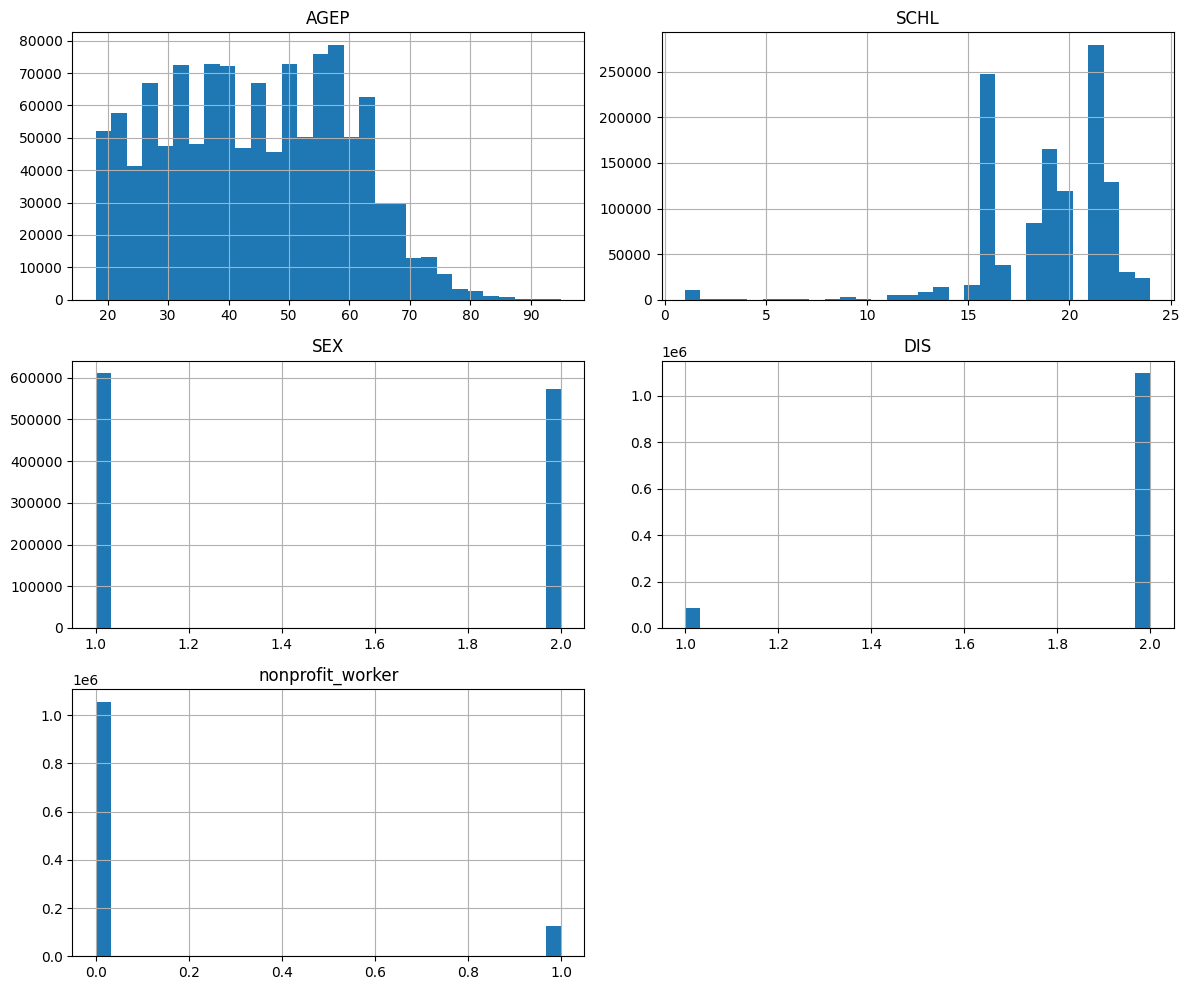

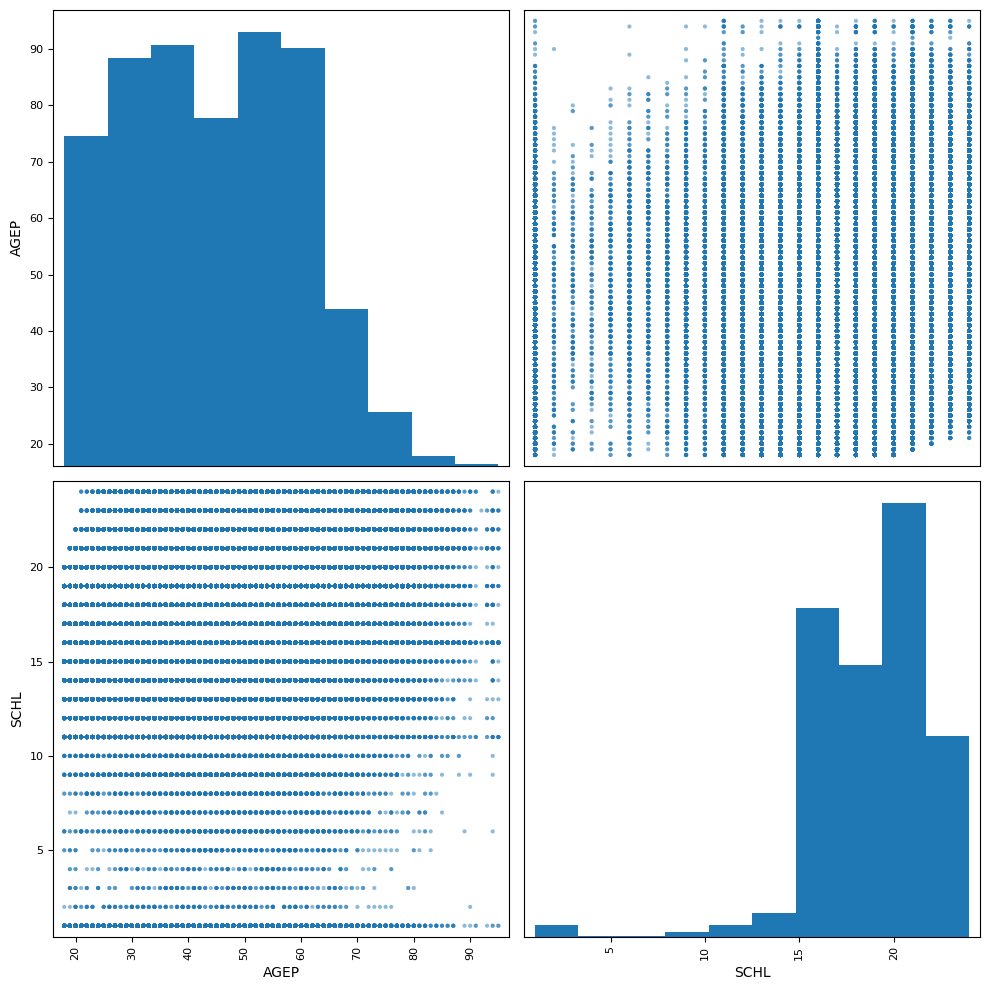

In [ ]:
# STEP 5: Visualizations with available columns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

# create lables
df["SEX_label"] = df["SEX"].map({1: "Male", 2: "Female"})
df["DIS_label"] = df["DIS"].map({1: "With Disability", 2: "No Disability"})

# plot histograms
_ = train_clean_df.hist(figsize=(12, 10), bins=30)
plt.tight_layout()
plt.show()

# Use numeric columns for scatter matrix (AGEP, SCHL)
sm_cols = [c for c in ["AGEP","SCHL"] if c in train_clean_df.columns]

# Plot scatter matrix if at least two numeric columns exits
if len(sm_cols) >= 2:
    _ = scatter_matrix(train_clean_df[sm_cols], figsize=(10, 10), diagonal="hist")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough numeric columns for scatter_matrix; skipping.")


**Step 6: Apply transformations to your data.** In your Jupetyr notebook apply, squaring, cubing, logarithmic, and exponentials transformations to two features in your dataset. Plot the histograms and scatter matrices of the resultant data.

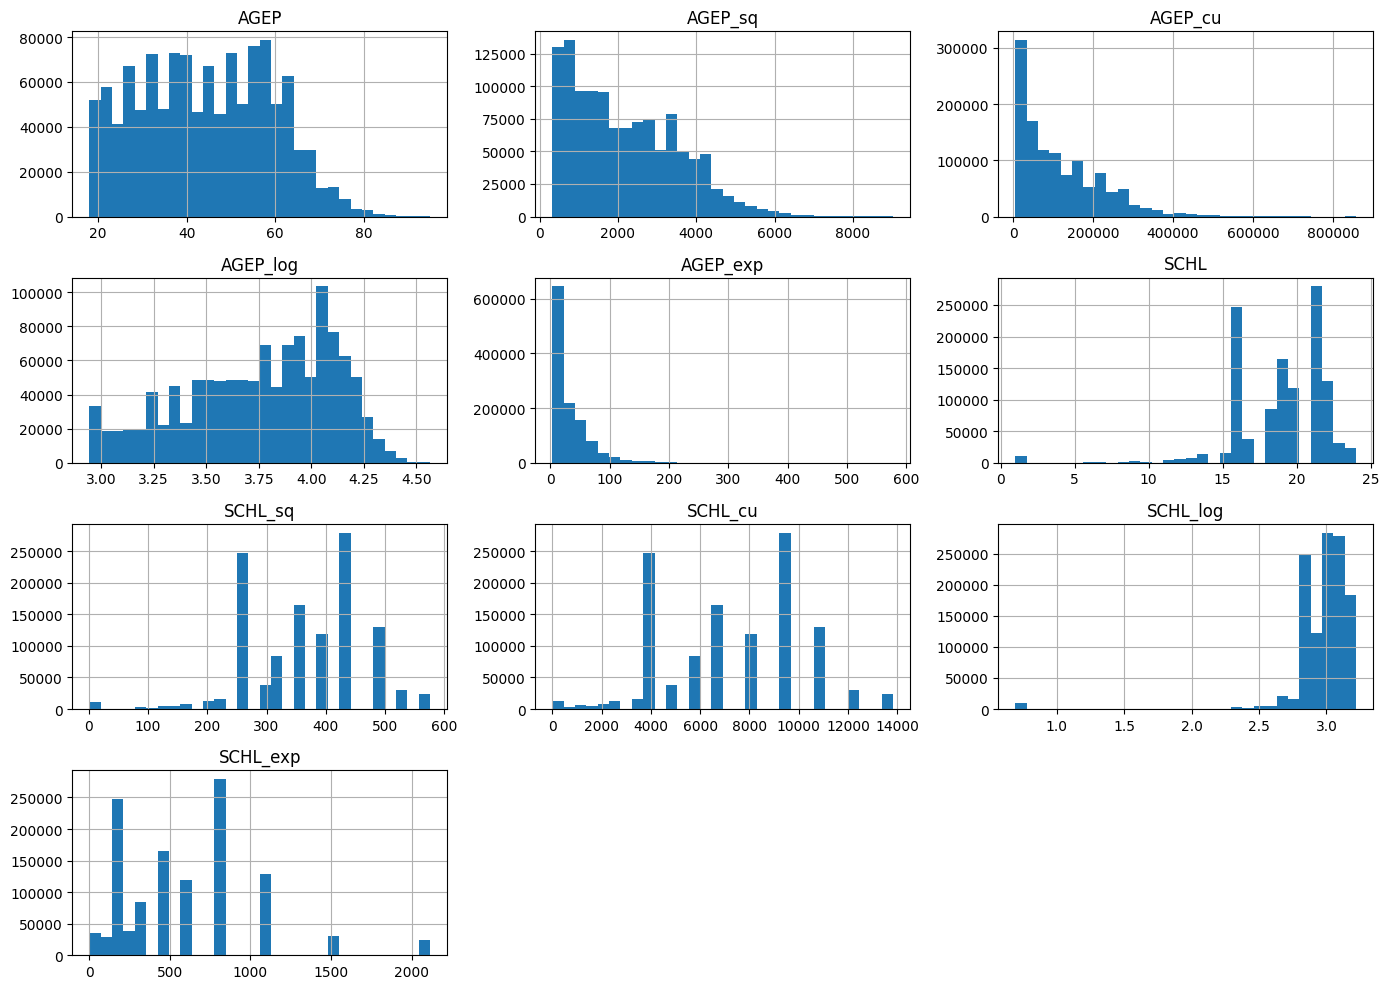

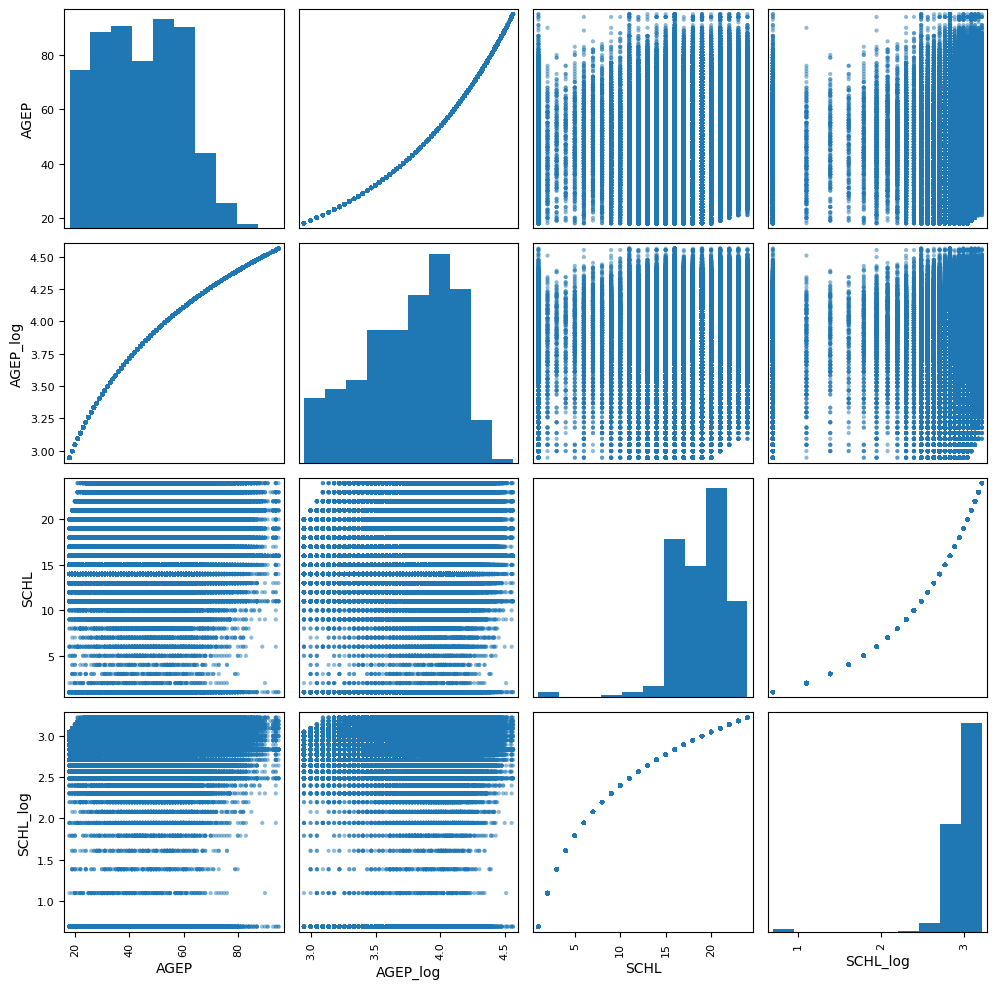

In [ ]:
# STEP 6: Transform AGEP and SCHL

import numpy as np #had to reload

# run logarithm func
def safe_log(x):
    return np.log1p(np.clip(x, a_min=0, a_max=None))

# run exponential func
def safe_exp(x):
    # avoid overflow in demo
    return np.exp(np.clip(x, a_min=None, a_max=12))

# bakcup copy to keep original unaltered
transformed = train_clean_df.copy()

# Transform by ietrating AGEP and SCHL
numeric_for_tx = []
for col in ["AGEP", "SCHL"]:
    if col in transformed.columns:
        transformed[f"{col}_sq"]  = transformed[col] ** 2
        transformed[f"{col}_cu"]  = transformed[col] ** 3
        transformed[f"{col}_log"] = safe_log(transformed[col])
        std = transformed[col].std() if transformed[col].std() else 1.0
        transformed[f"{col}_exp"] = safe_exp(transformed[col] / std)
        numeric_for_tx.extend([col, f"{col}_sq", f"{col}_cu", f"{col}_log", f"{col}_exp"])

# plot histogram for aviable variables
if numeric_for_tx:
    _ = transformed[numeric_for_tx].hist(figsize=(14, 10), bins=30)
    import matplotlib.pyplot as plt
    plt.tight_layout()
    plt.show()

# plot scatter for the variables
    from pandas.plotting import scatter_matrix
    sm_show = [c for c in ["AGEP","AGEP_log","SCHL","SCHL_log"] if c in transformed.columns]
    if len(sm_show) >= 2:
        _ = scatter_matrix(transformed[sm_show], figsize=(10, 10), diagonal="hist")
        plt.tight_layout()
        plt.show()
else:
    print("AGEP/SCHL not available; skipping transformations.")
